Notebook for the RNA velocity analysis shown in Figure 1 and S2.

Note the difference between the analysis using all of INTepi for Figure 1 and the data shown in Figure S2 just on 4 key conditions.

In [1]:
import os
import rpy2
import rpy2.situation

import re
import numpy as np
import pandas as pd
import anndata as ad
import scvelo as scv
import scanpy as sc
import cellrank as cr


print(os.getcwd())
base_dir = f"{os.getcwd()}"
for row in rpy2.situation.iter_info(): # Print Rpy2 info
    print(row)

/Users/ferran/Dropbox (UCL)/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/Figure1-S1-S2
rpy2 version:
3.4.5
Python version:
3.9.15 (main, Oct 11 2022, 22:27:25) 
[Clang 14.0.0 (clang-1400.0.29.102)]
Looking for R's HOME:
    Environment variable R_HOME: None
    Calling `R RHOME`: /usr/local/Cellar/r/4.2.2/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:
/usr/local/lib/R/library/stats/libs/
R version:
    In the PATH: R version 4.2.2 (2022-10-31) -- "Innocent and Trusting"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/usr/local/Cellar/r/4.2.2/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'icucore', 'dl', 'm', 'iconv']
  library_dirs:
  ['/usr/local/opt/gettext/lib', '/usr/local/opt/readline/lib', '/usr/local/opt/xz/lib', '/usr/local/lib', '/usr/local/opt/gettext/lib', '/usr/local/opt/r

In [2]:
%load_ext rpy2.ipython

In [3]:
#Define input directory

data_dir = "../ZenodoRepo/"

# INTepi Object

In [4]:
#You can replace the local path to the downsampled object for the full one in Zenodo

from rpy2.robjects.packages import importr
base = importr("base")

downsampled_INTepi = base.readRDS("data/downsampled_INTepi.rds")

R[write to console]: Loading required package: SeuratObject

R[write to console]: Attaching sp



In [5]:
%%R -i downsampled_INTepi
library(tidyverse)
library(Seurat)

downsampled_INTepi

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.1 

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



An object of class Seurat 
31434 features across 324 samples within 2 assays 
Active assay: RNA (27434 features, 0 variable features)
 1 other assay present: integrated
 7 dimensional reductions calculated: pca, umap, phate, pca_epi, umap_epi, phate_epi, phate_epi2


First we exported the metadata information about clusters and phate embeddings from the Seurat object with the outlier clusters removed as follows (in R):

    data.table::fwrite(
        subset(INTepi, 
            subset = curatedCLUST %in% c(
                                        "CSC", "proCSC",
                                        "revCSC","TA 1","TA 2",
                                        "ER Stress","Goblet / DCS",
                                        "Early Enterocyte","Late Enterocyte"
                                        )
            )@meta.data,
        file = "data/INTepi_meta.csv",
        append=FALSE,
        row.names=TRUE
    )
    data.table::fwrite(
        as.data.frame(Embeddings(
            subset(INTepi, 
            subset = curatedCLUST %in% c(
                                        "CSC", "proCSC",
                                        "revCSC","TA 1","TA 2",
                                        "ER Stress","Goblet / DCS",
                                        "Early Enterocyte","Late Enterocyte"
                                        )
            ),
            reduction = "phate_epi"
        )),
        file = "data/INTepi_phate.csv",
        append=FALSE,
        row.names=TRUE
    )

Then we can read and import them into python

    d_meta = (
        pd.read_csv("data/meta_INTepi.csv")
        .rename(columns={"Unnamed: 0":"CellID"})
    )
    d_phate = (
        pd.read_csv("data/phate_INTepi.csv")
        .rename(columns={"Unnamed: 0":"CellID"})
    )

To compute RNA velocity, first unzip the `RNA Velocity (loom files).zip` directory and move it's contents to the ZenodoRepo folder.

Then create an AnnData object parsing through the loom files and the metadata file:

    sample_list = d_meta["orig.ident"].unique().tolist()
    #Initialise AD object with the WT organoid monoculture from the first run
    adINTepi21 = ad.read_loom(
        "../ZenodoRepo/01_WT_1.loom")
    #Make var_names unique
    if len(adINTepi21.var_names) != len(set(adINTepi21.var_names)):
        print("Making var_names unique by appending -n")
        adINTepi21.var_names_make_unique()
    #Clean-up CellID column
    adINTepi21.obs = adINTepi21.obs.rename(
            index = lambda x: re.sub(pattern="(^\d.+:)", 
                                    repl="", string=x)
        )
    adINTepi21.obs = adINTepi21.obs.rename(
            index = lambda x: re.sub(pattern="(x$)", 
                                    repl=f"-1_{(1+sample_list.index(sample_list[0]))}", 
                                    string=x)
        )
    #Process and add the mising loom files (pseudocode)
    for each sample in sample_list[1:]:
        1) read corresponding loom file
        2) make var_names unique
        3) clean-up CellID
        4) Merge sample AnnData object with adINTepi21
    #Further CellID clean-up
    adINTepi21 = adINTepi21[np.isin(adINTepi21.obs.index, d_meta["CellID"])]
    #Add metadata to .obs slot
    d_meta_ordered = pd.DataFrame(adINTepi21.obs.index).merge(d_meta, on="CellID")
    adINTepi21.obs["orig.ident"] = d_meta_ordered["orig.ident"].values
    adINTepi21.obs["CRCTME"] = d_meta_ordered["CRCTME"].values
    adINTepi21.obs["curatedCLUST"] = d_meta_ordered["curatedCLUST"].values
    #Add PHATE embedding to .obsm
    d_phate_ordered = pd.DataFrame(adINTepi21.obs.index).merge(d_phate, on="CellID")
    adINTepi21.obsm["X_phate"] = d_phate_ordered.drop(columns="CellID").values

QC and compute moments for RNA velocity

    scv.pp.filter_and_normalize(adINTepi21, 
        min_shared_counts=20, 
        n_top_genes=4000)
    scv.pp.moments(adINTepi21, 
        n_pcs=50, 
        n_neighbors=30)

Compute RNA velocity with scvelo

    scv.tl.recover_dynamics(
        adINTepi21,
        n_jobs=12,
        plot_results=False
    )
    scv.tl.velocity(
        adINTepi21,
        mode="dynamical"
    )
    scv.tl.velocity_graph(adINTepi21)

(-0.025, 0.07)

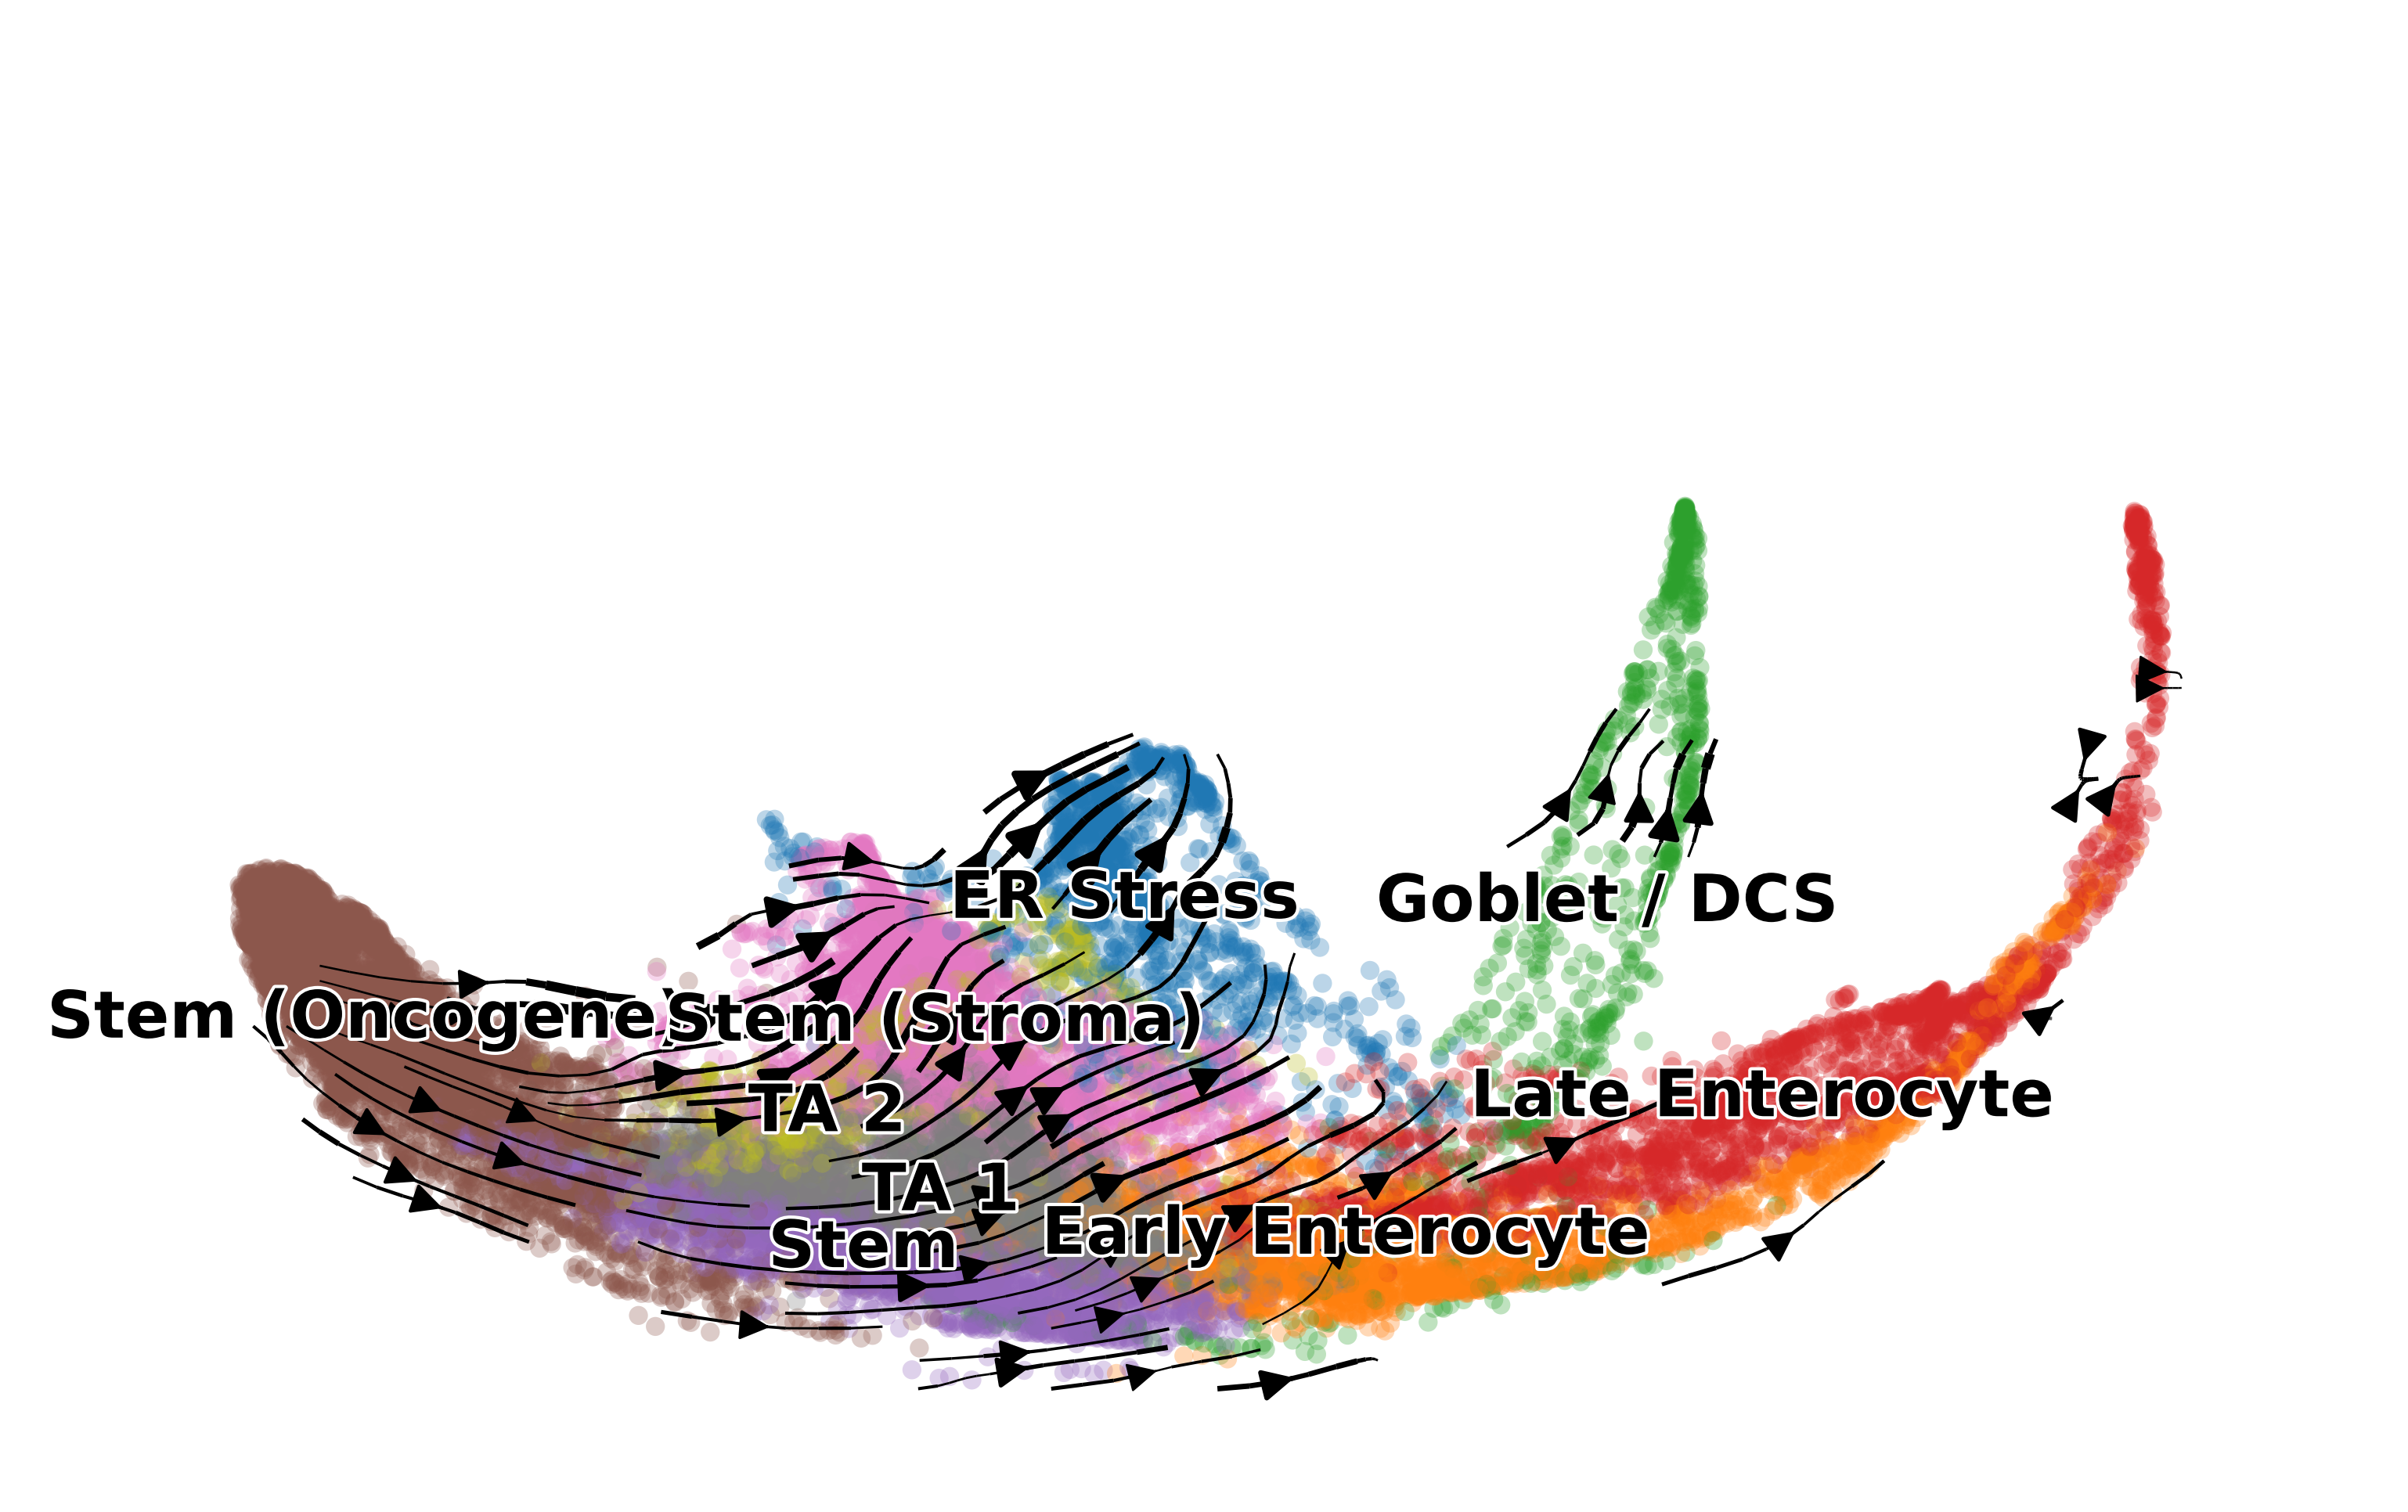

In [6]:
#The velocity embedding streams (arrows) were then overlaid on top of plot in Figure 2B

adINTepi21 = sc.read_h5ad(f"{data_dir}scvelo_INTepi.h5ad")
plt_stream_embedding = scv.pl.velocity_embedding_stream(
    adINTepi21,
    basis="X_phate",
    # smooth=0.8,
    # min_mass=4,
    color="curatedCLUST",
    color_map=None,
    dpi=600,
    show=False
)
plt_stream_embedding.set_title(None)
plt_stream_embedding.set_xlabel(None)
plt_stream_embedding.set_ylabel(None)
plt_stream_embedding.set_xlim([-0.032,0.05])
plt_stream_embedding.set_ylim([-0.025,0.07])


# 4 CONDITIONS

In order to compare four pivotal conditions of our experiment in a more focused manner, we created an object with cells from the following samples, grouped according to their CRCTME metadata label:

    ad4Cond = adINTepi21[adINTepi21.obs["orig.ident"].isin(["monoWT", "WTorg_mono",
                                                        "monoAK",
                                                        "cocultWTFib",
                                                        "WTorg_WENR"])]

Then, the RNA velocity analysis with scvelo was performed again as shown above, and we compared RNA velocity vector length changes (a measure of transcriptional dynamic rates) across the four metadata labels

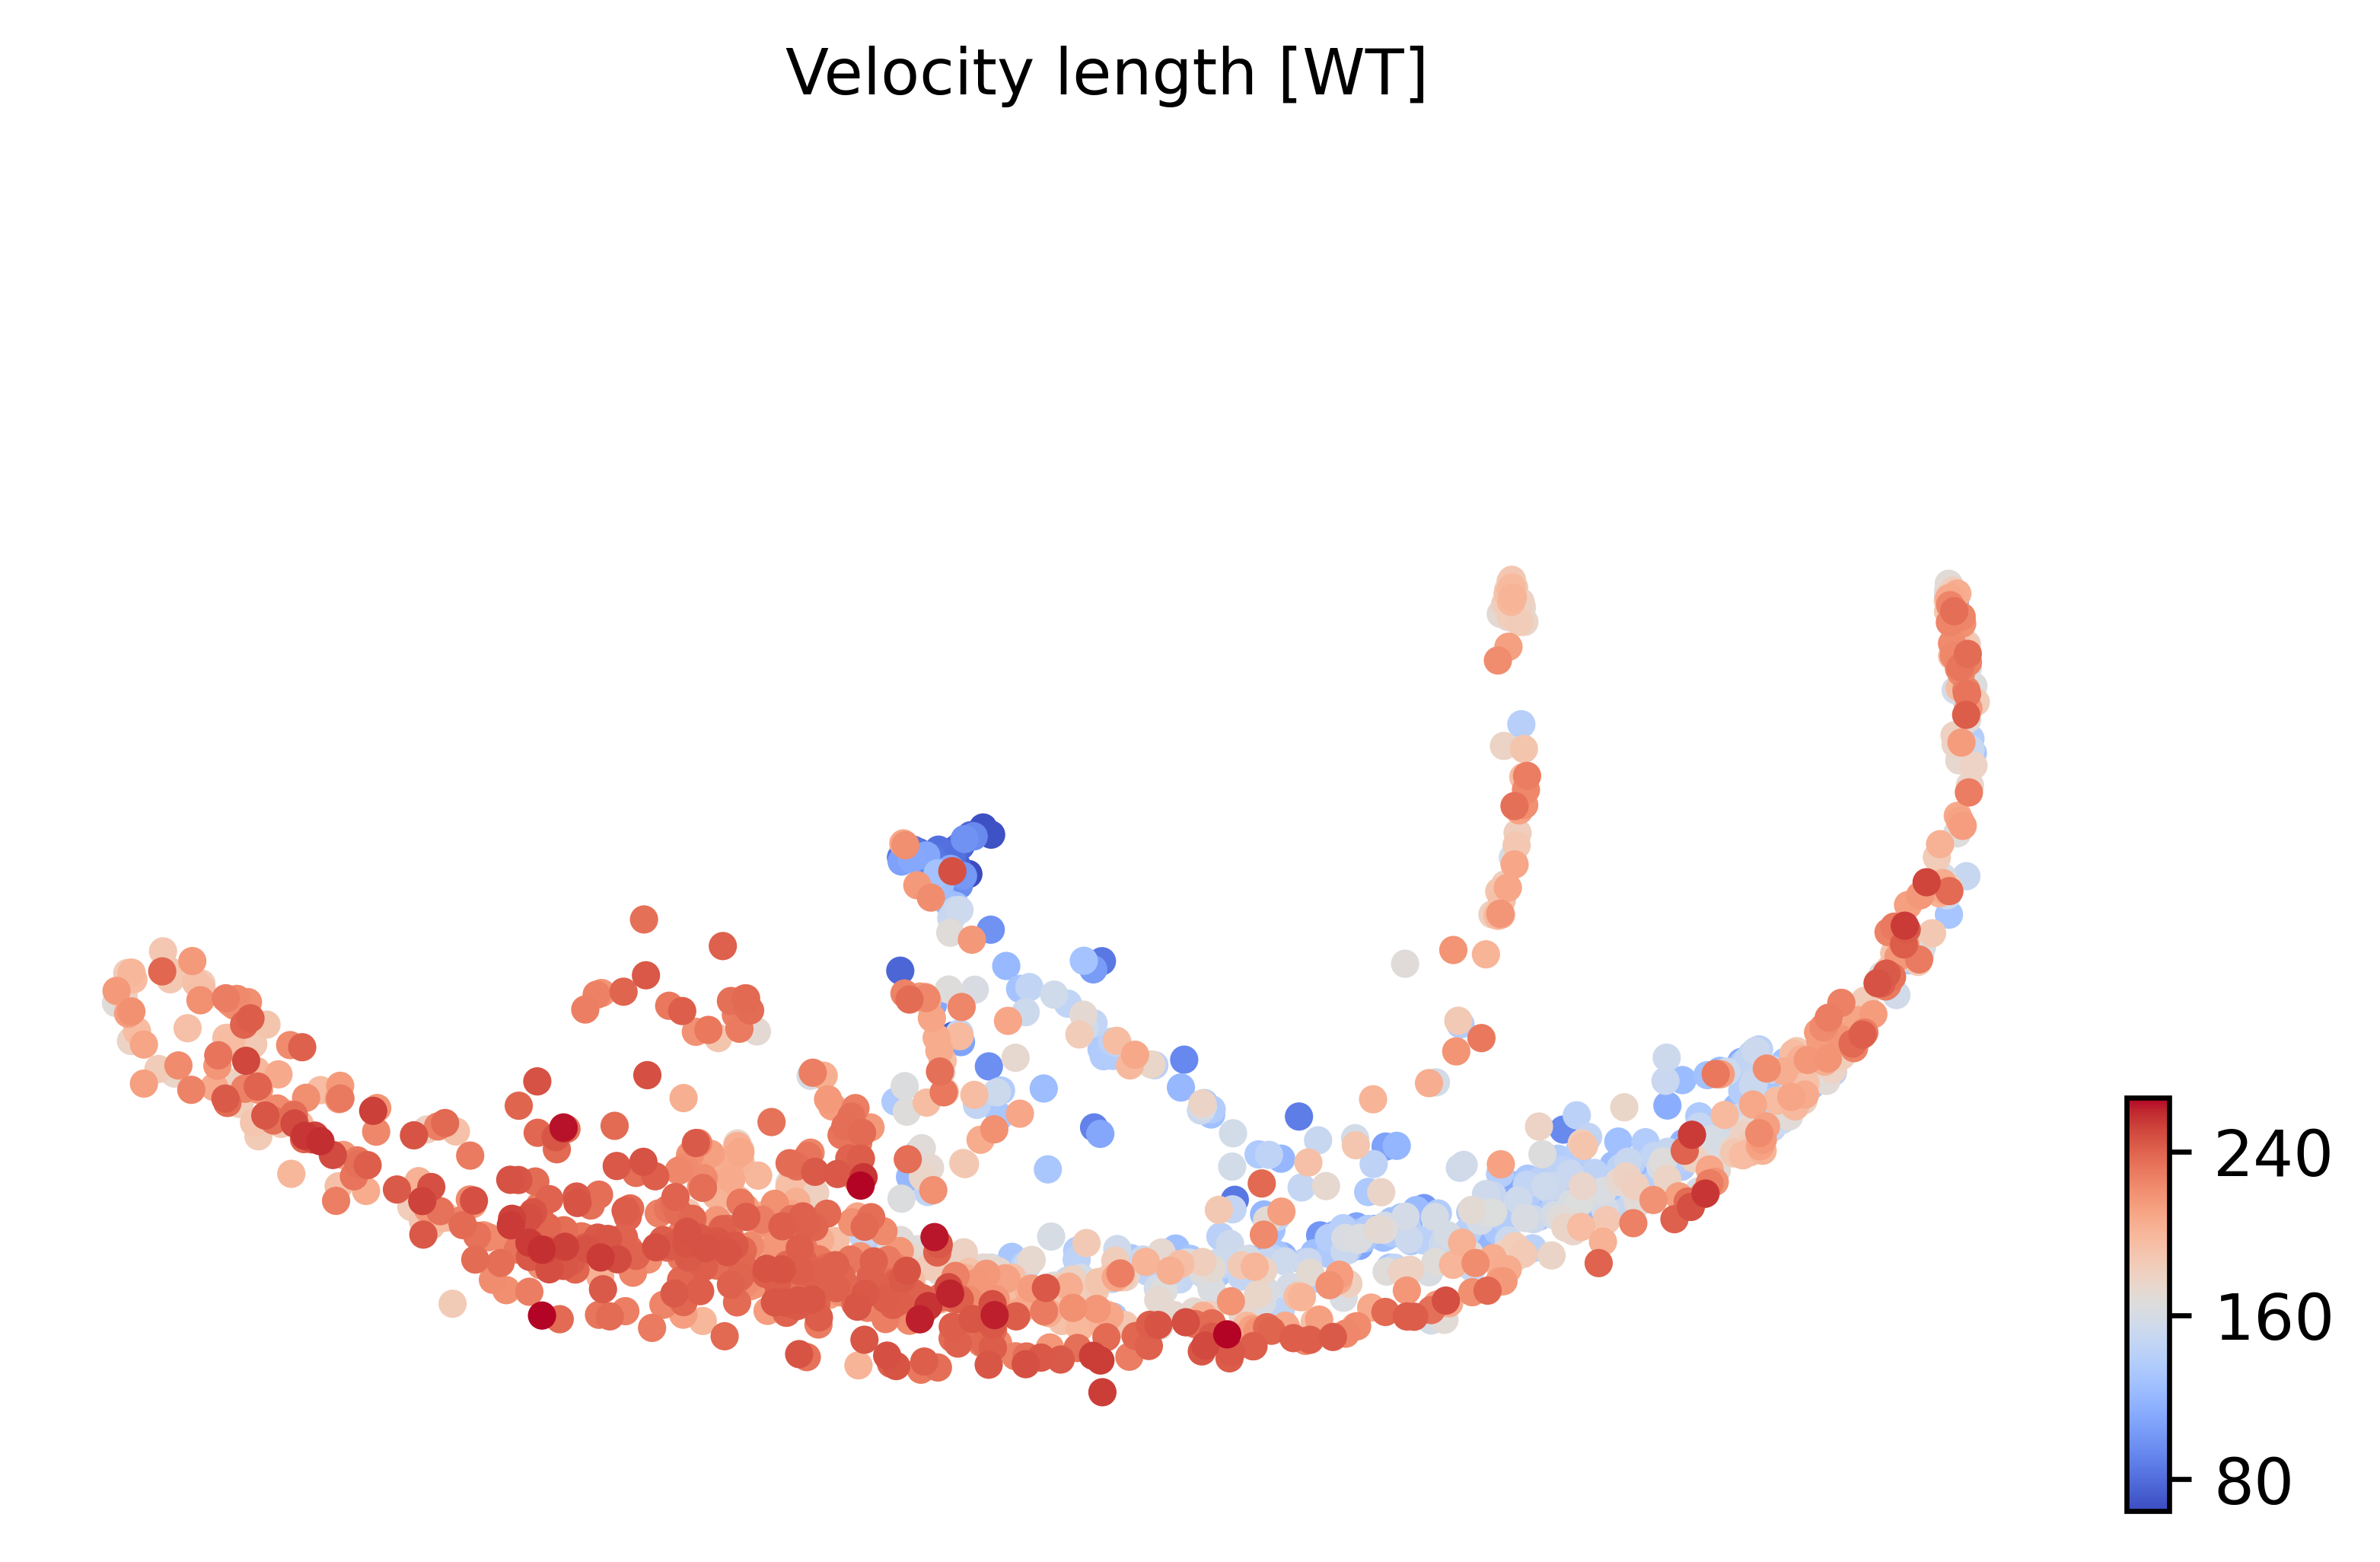

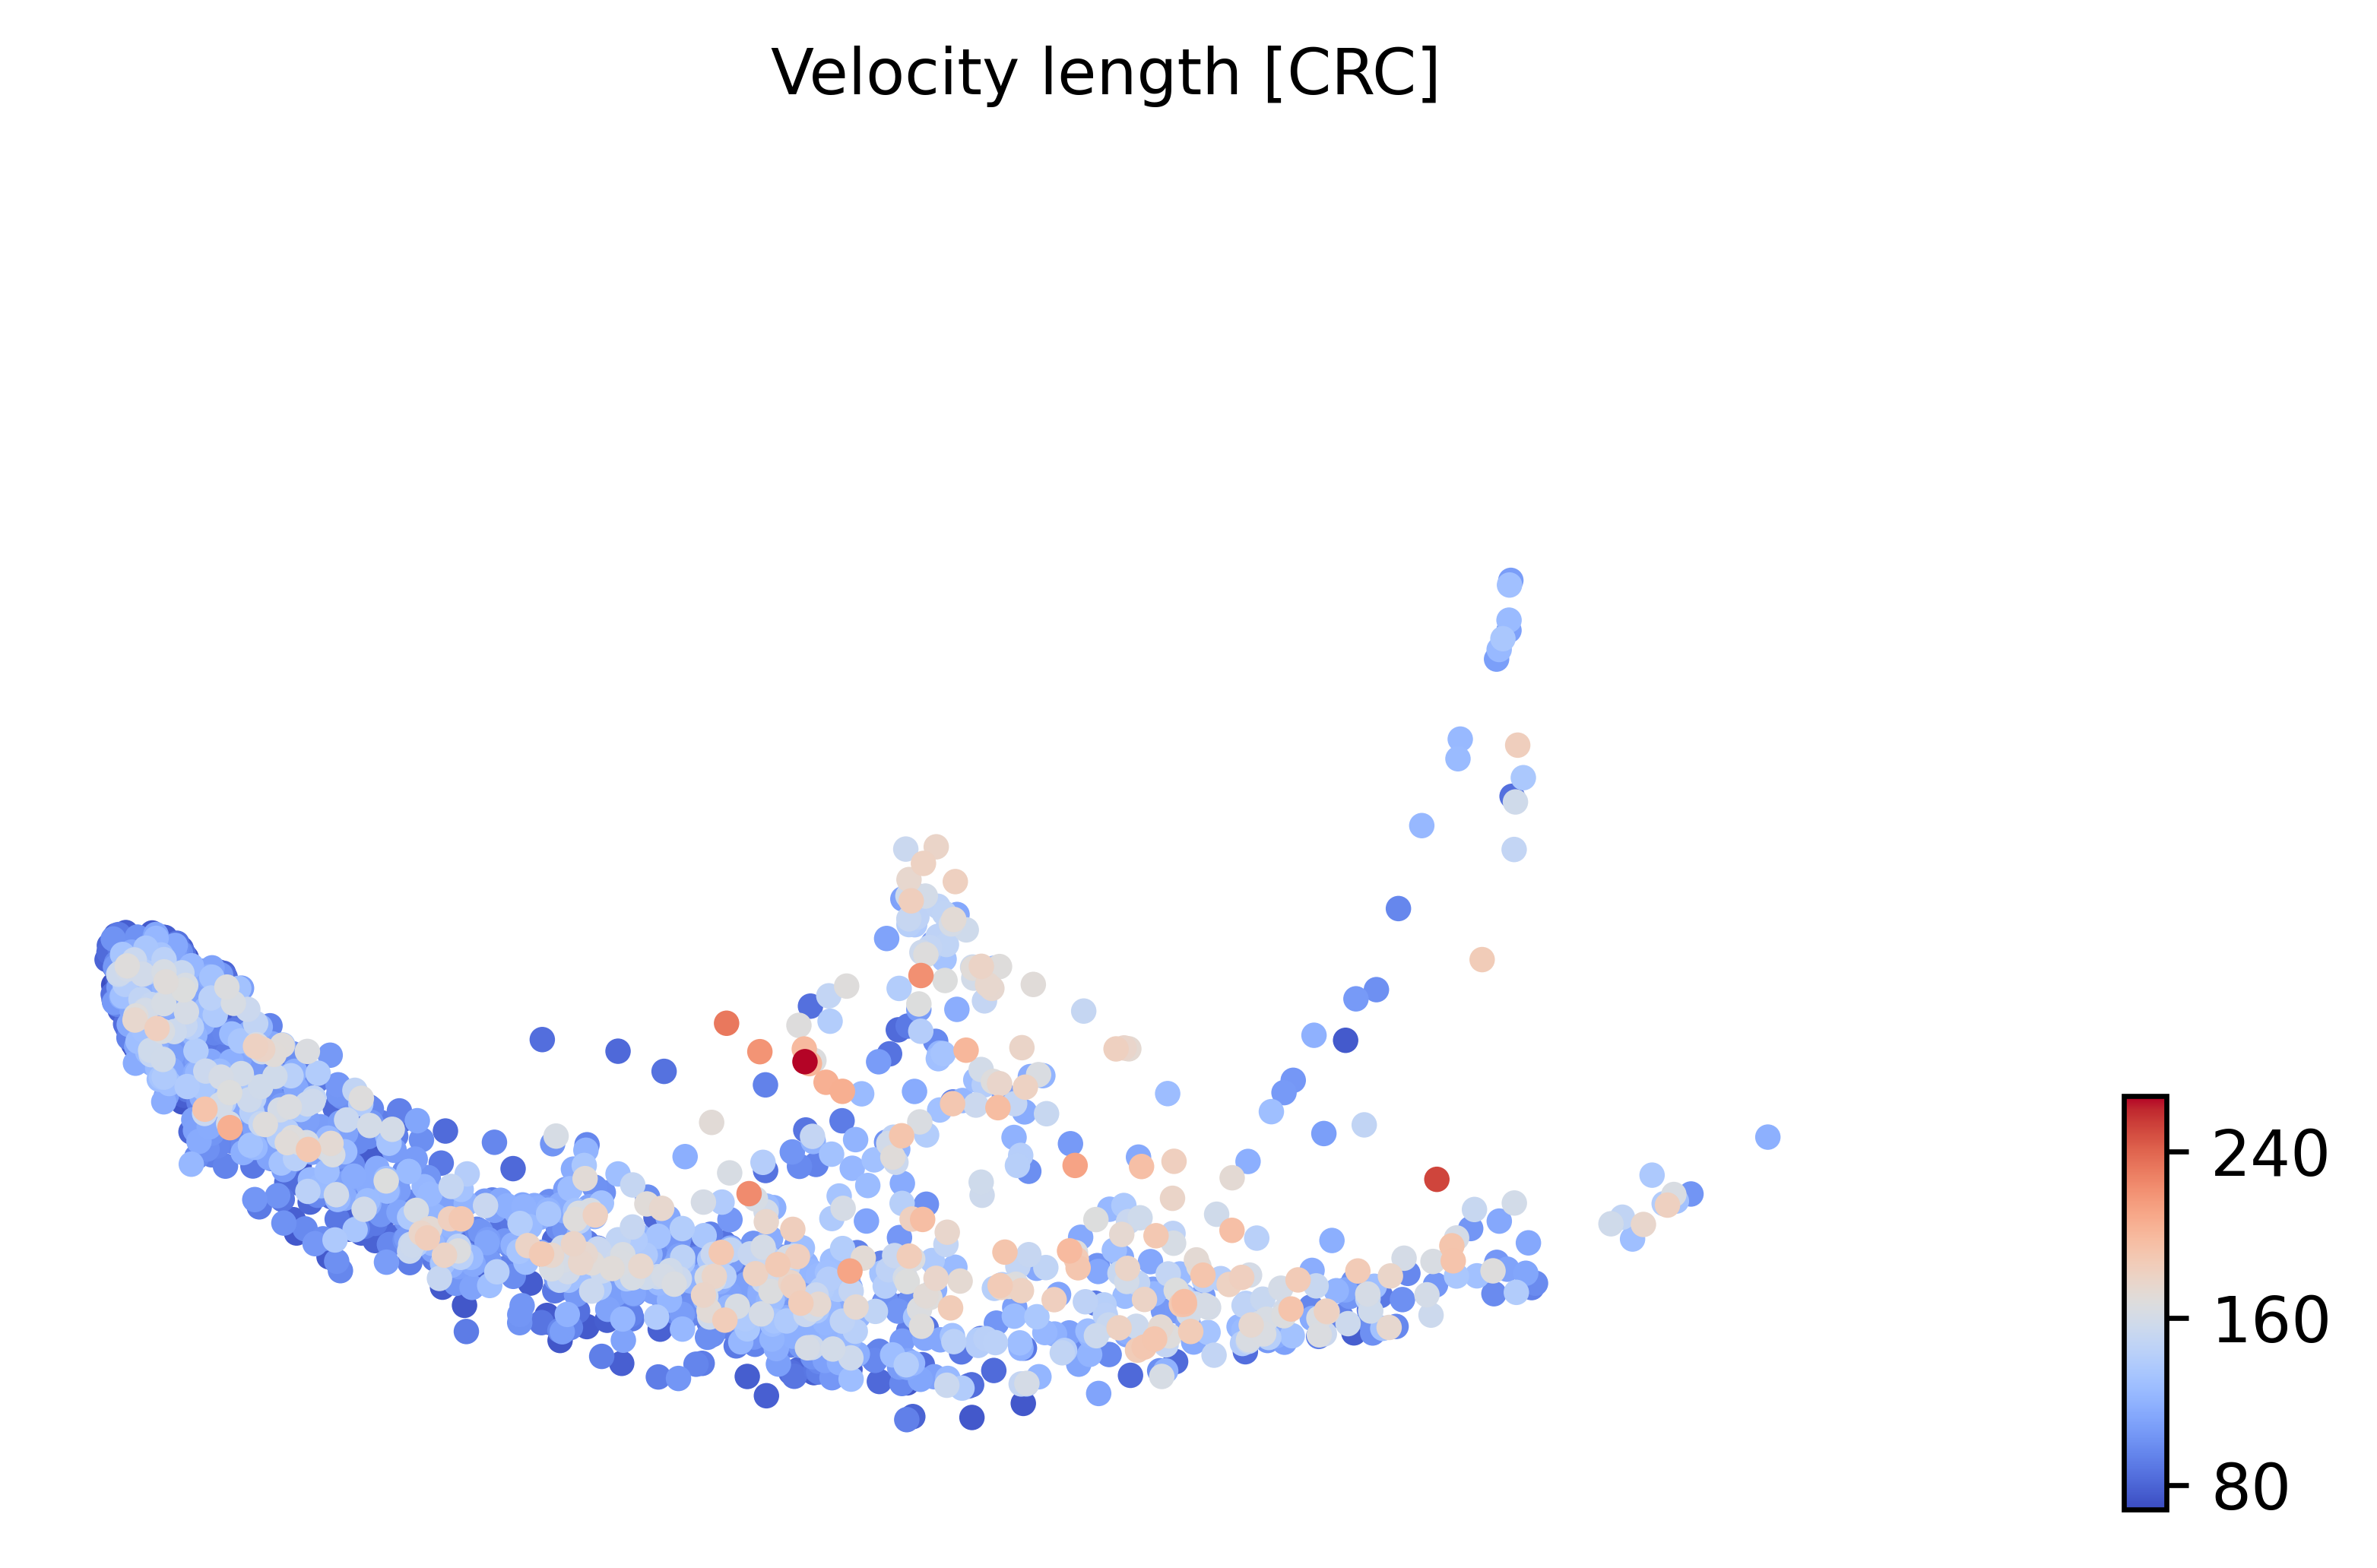

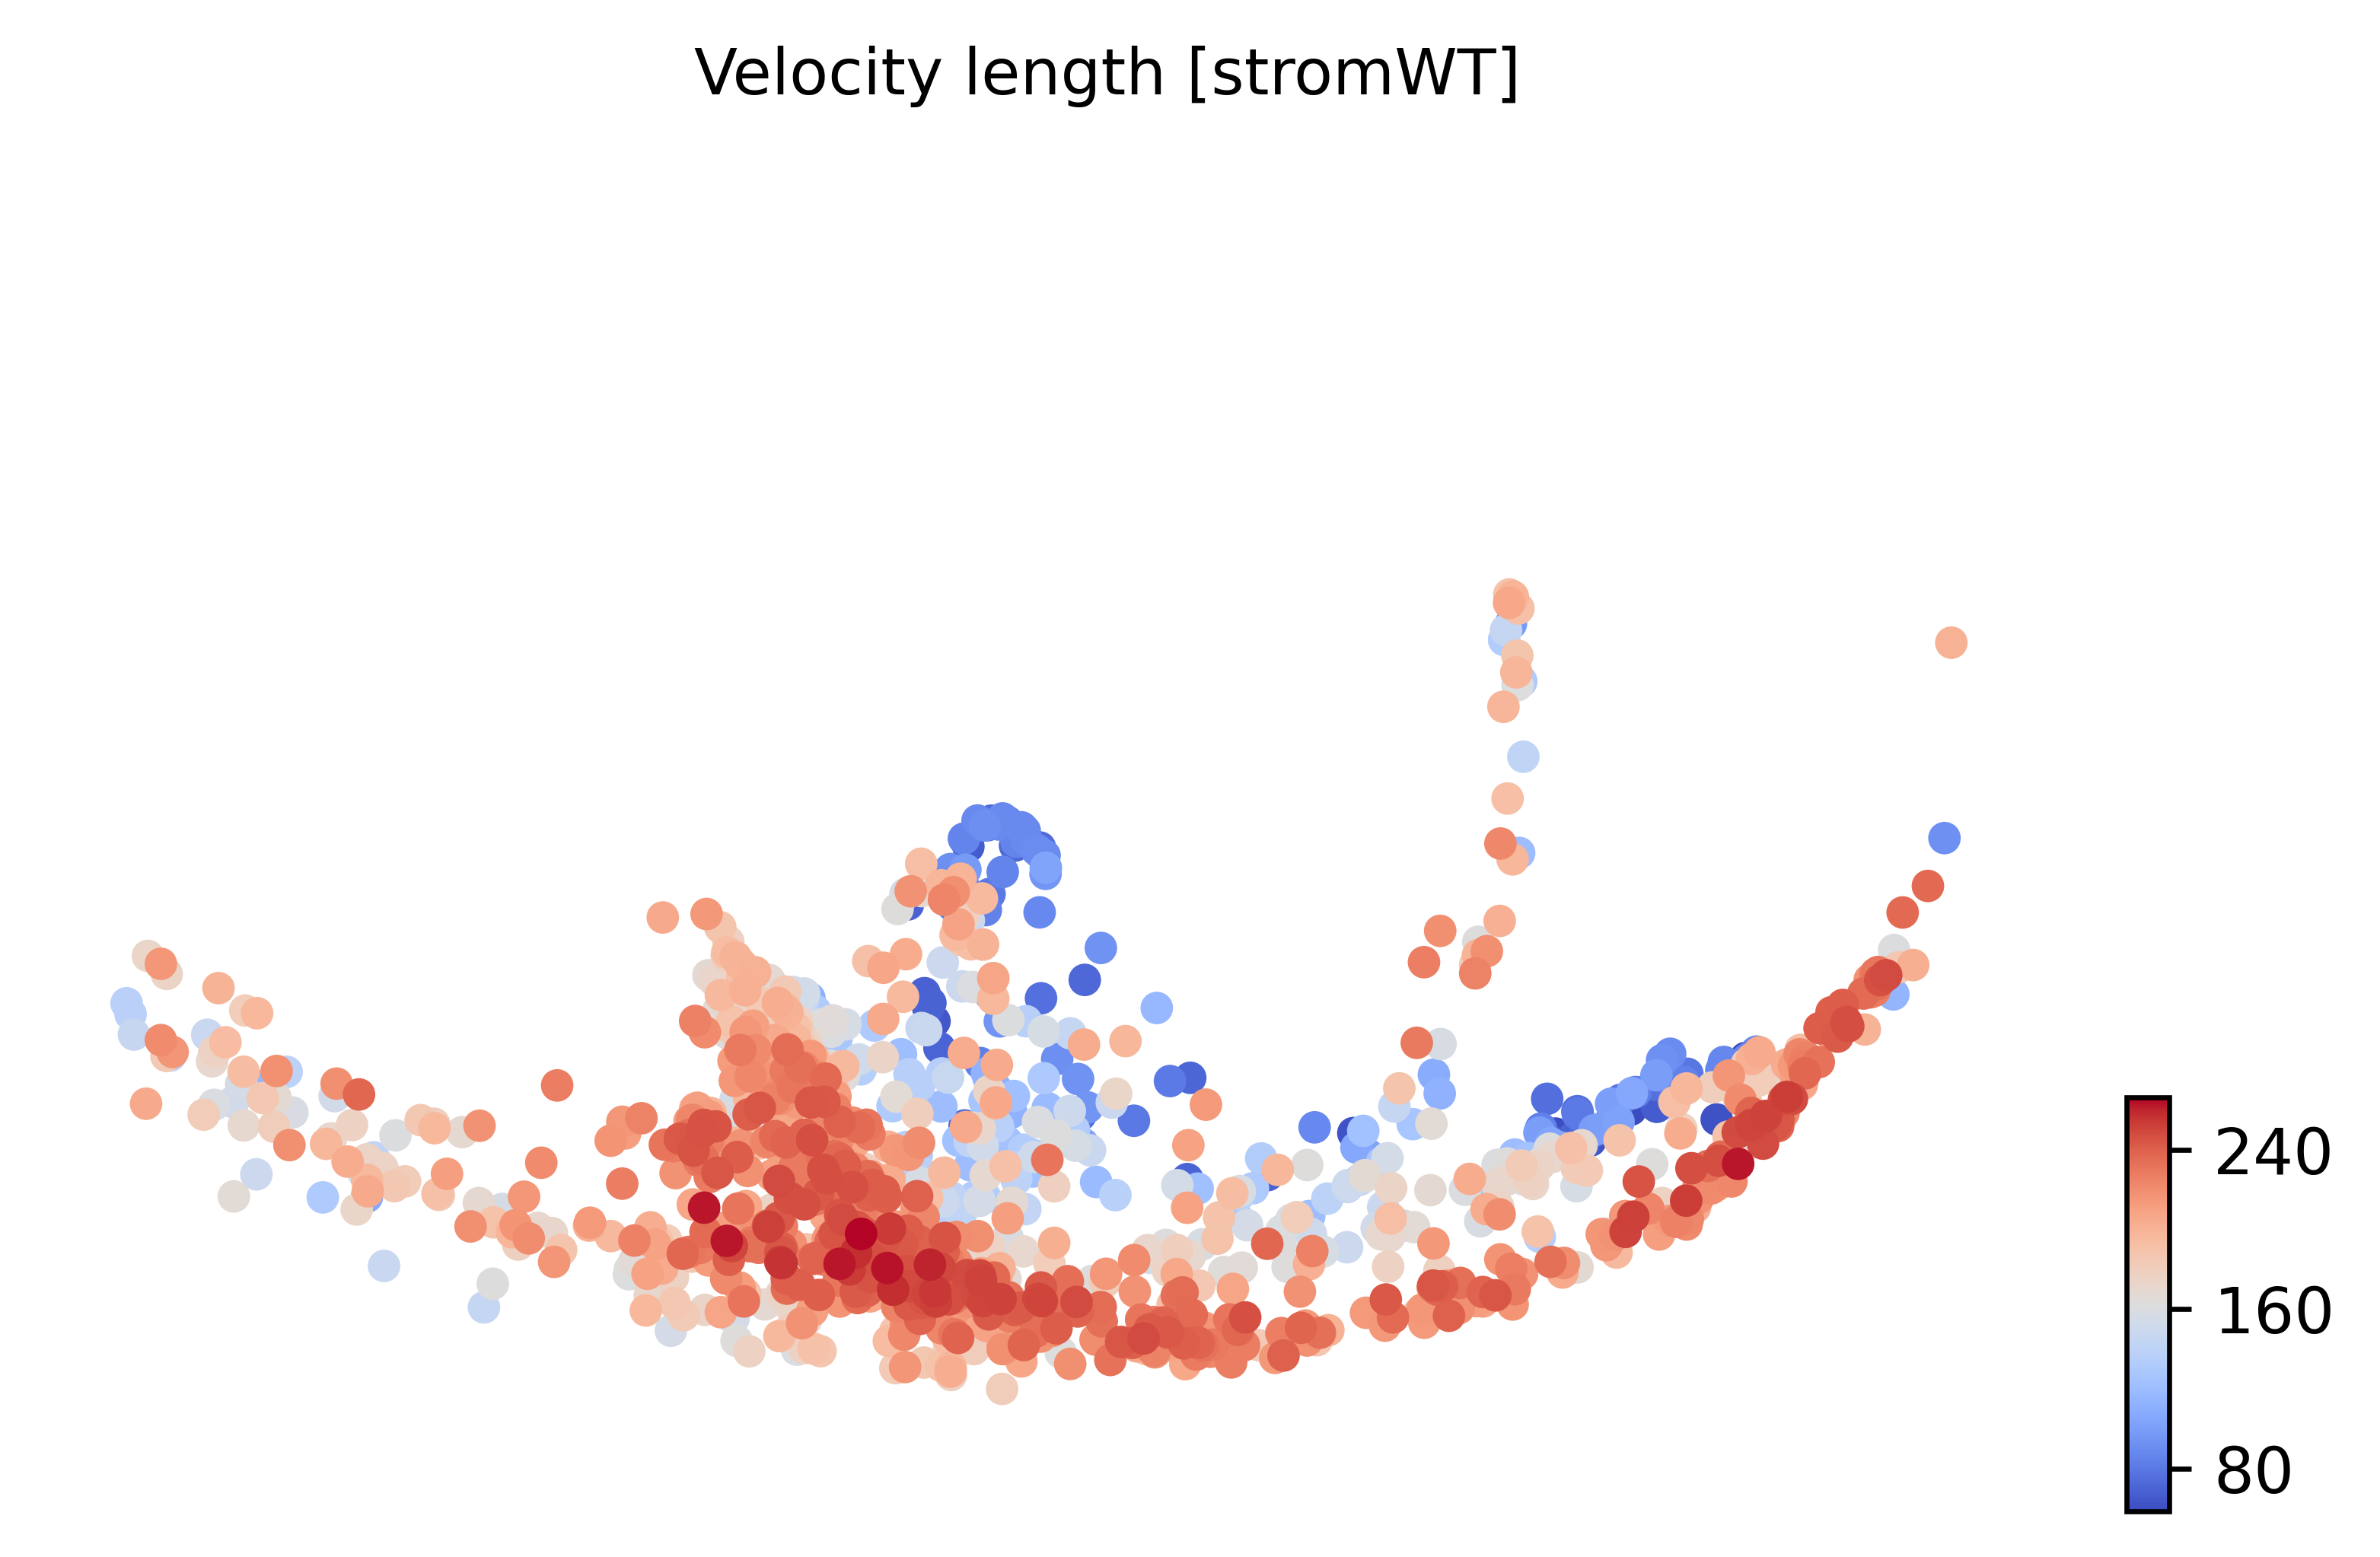

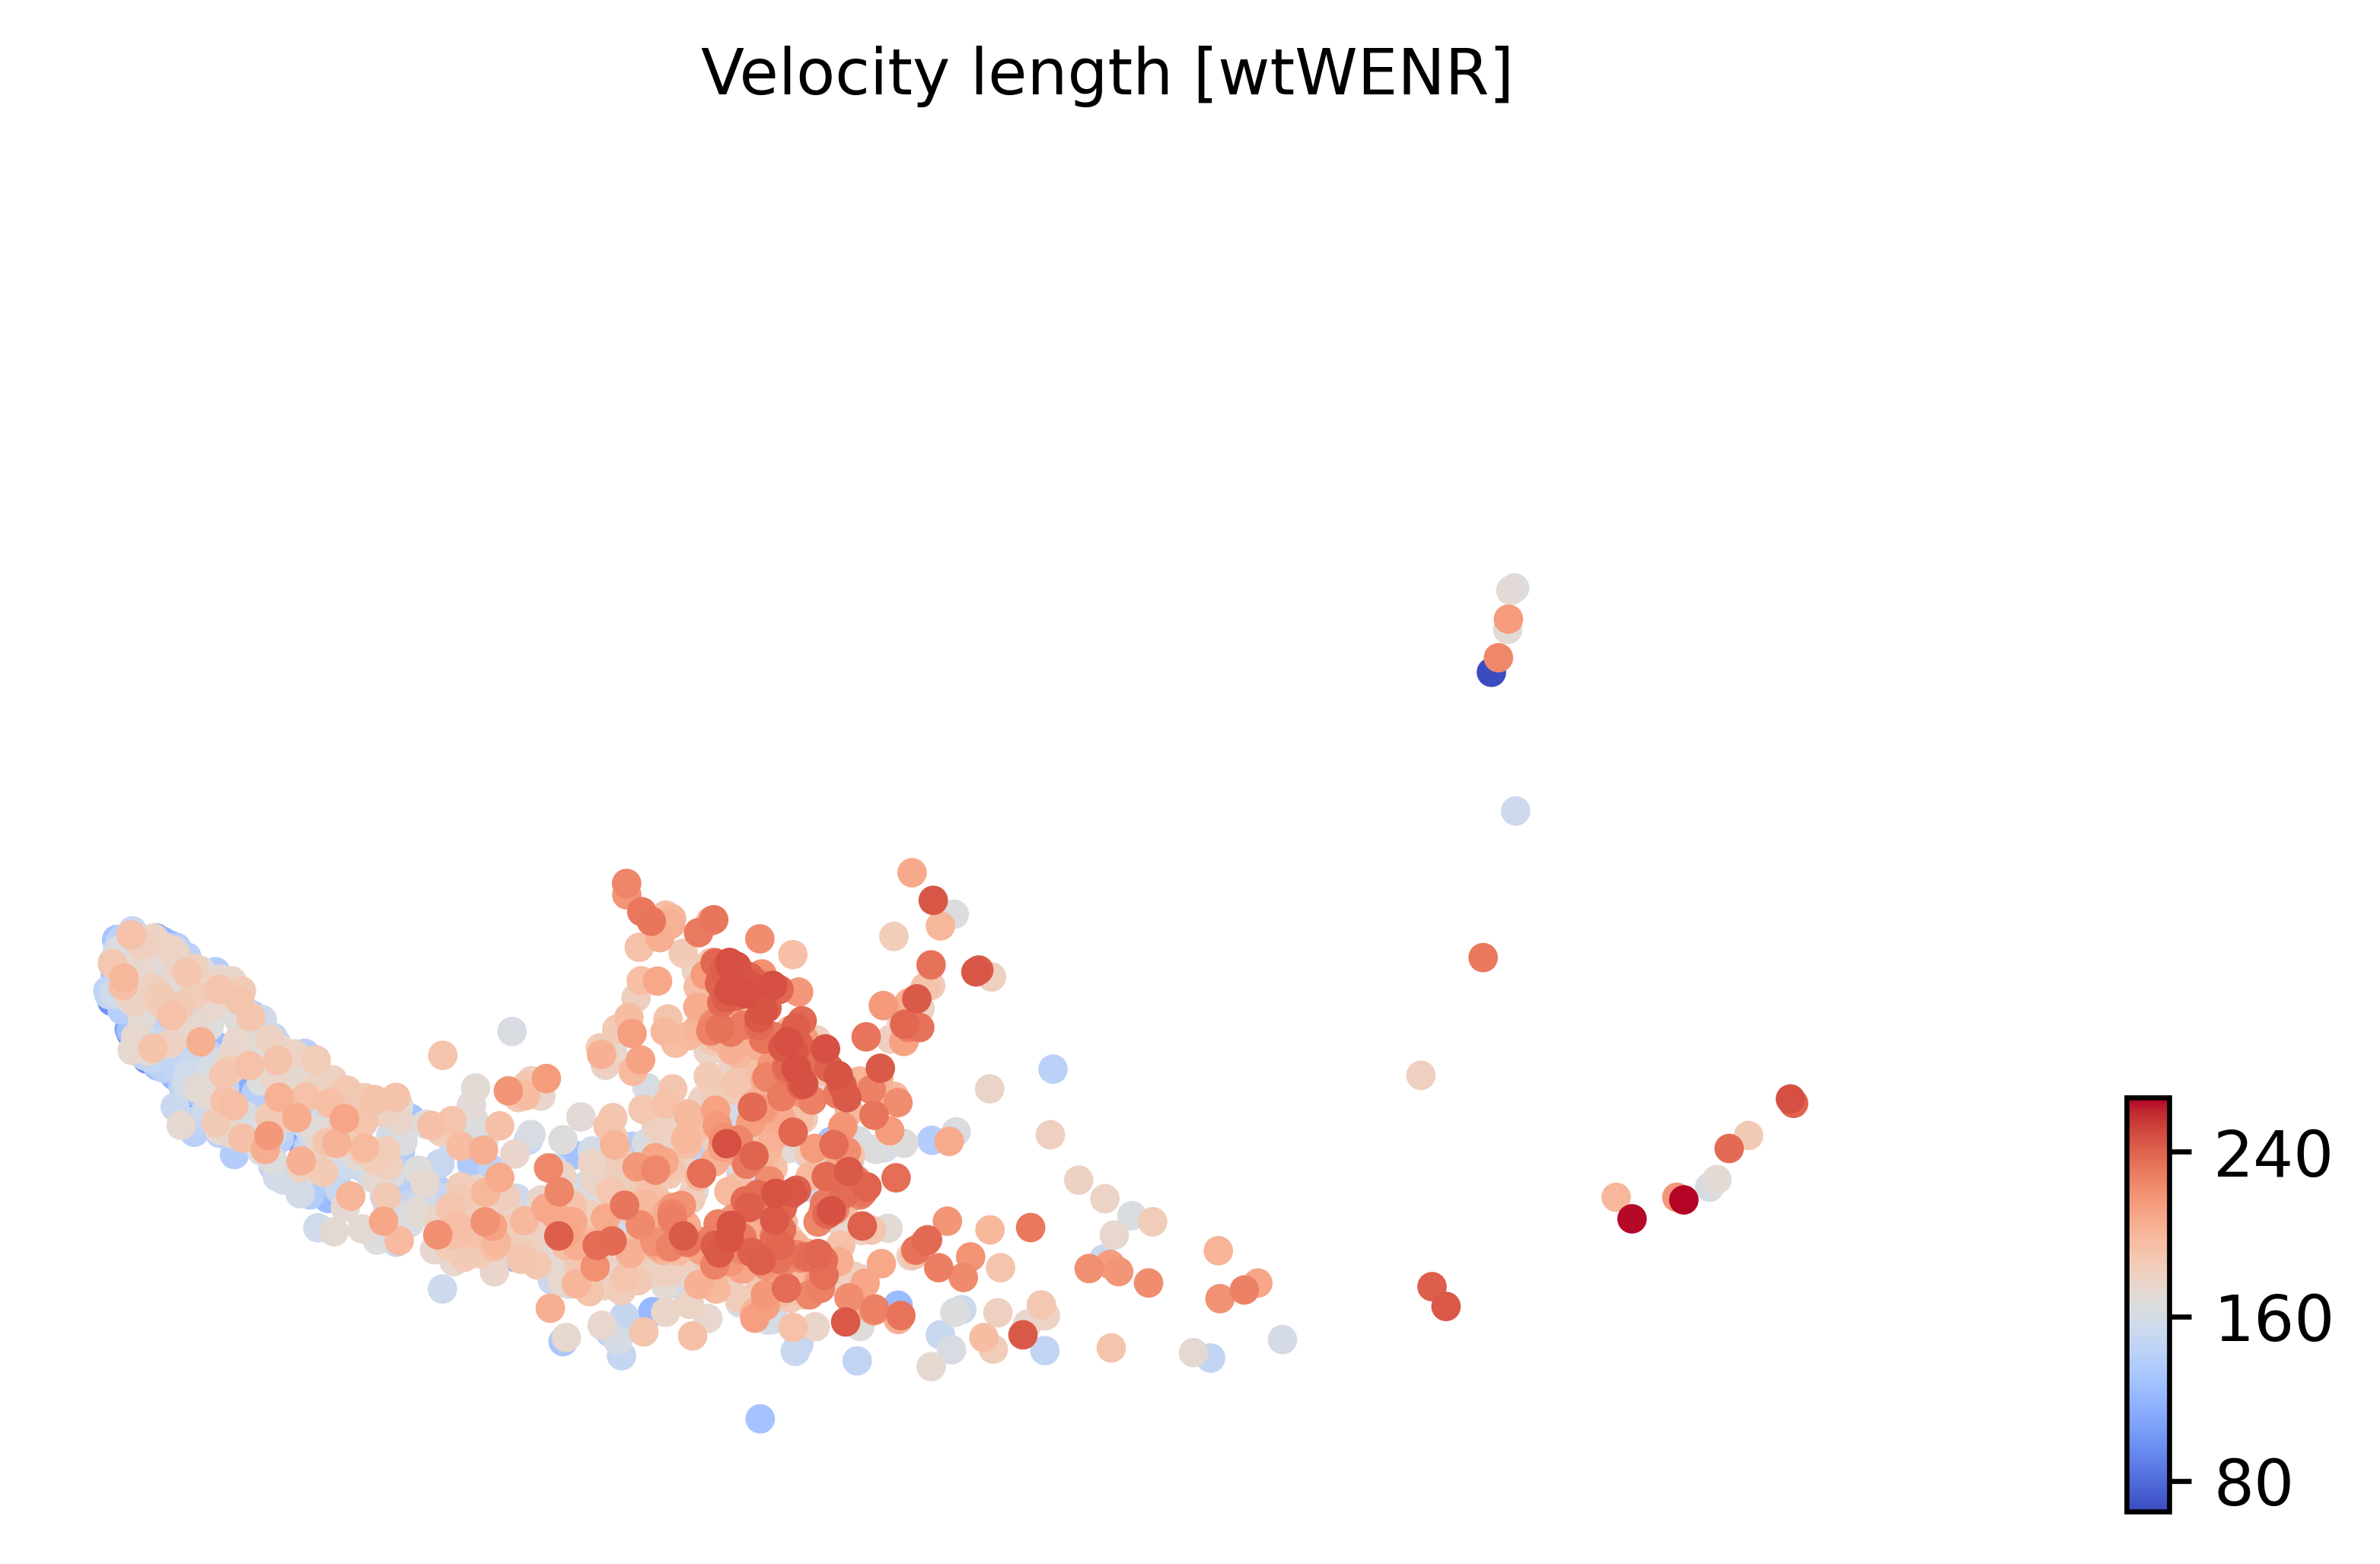

In [7]:
#Recreate RNA velocity length plots

ad4Cond = sc.read_h5ad(f"{data_dir}scvelo_4Cond.h5ad")
vLength = ad4Cond.obs["velocity_length"].quantile(q=[0.05,0.95])
for i in ad4Cond.obs["CRCTME"].unique().tolist():
    plot_vLength = scv.pl.scatter(
                ad4Cond[ad4Cond.obs["CRCTME"] == i, :], 
                c="velocity_length",
                cmap='coolwarm', rescale_color=[vLength[0.05],vLength[0.95]],
                basis="X_phate",
                title=f"Velocity length [{i}]",
                show=False,
                xlim=[-0.032,0.05], ylim=[-0.025,0.07],
                dpi=600)
    plot_vLength

The violin plots in FigS2D were generated in R after importing the RNA velocity vector length into the Seurat object as a metadata layer:

    INTepi <- AddMetaData(INTepi, 
                    metadata=(ad4Cond.obs %>% column_to_rownames(var="CellID") %>% select("velocity_length")))
    INTepi

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



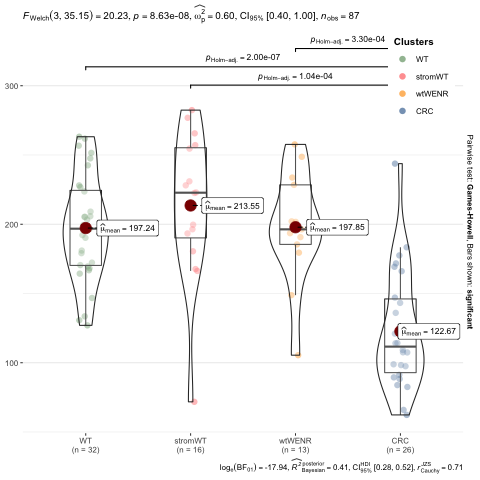

In [8]:
%%R -i downsampled_INTepi
#Recreate the plots using the downsampled object:

    ggstatsplot::ggbetweenstats(downsampled_INTepi@meta.data,
                                x = CRCTME,
                                y = velocity_length,
                                type="p",
                                plot.type = "boxviolin",
                                #point.args = c(size=0)
                                ) +
    scale_color_manual(values = c("#669966","#FF6666","#FF9900","#336699")) +
    theme(
        legend.position = c(.98, 1),
                                legend.justification = c("right", "top"),
                                legend.box.just = "right",
                                legend.margin = margin(6, 6, 6, 6),
                                panel.grid.major.x = element_blank()
                                    ) +
    labs(title = NULL, x=NULL, y=NULL, colour="Clusters")

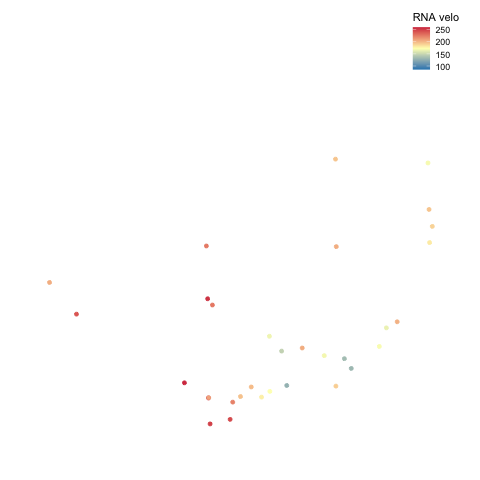

In [9]:
%%R -i downsampled_INTepi

veloQcolours <- quantile(downsampled_INTepi@meta.data$velocity_length, c(0.05,0.95), na.rm = TRUE)

ggplot(
  as.data.frame(subset(downsampled_INTepi, subset=(
                              CRCTME=="WT" & curatedCLUST%in%c(
                                "CSC", "proCSC", "revCSC","TA 1","TA 2", 
                                "ER Stress","Goblet / DCS","Early Enterocyte","Late Enterocyte"))
                       )@reductions$phate_epi@cell.embeddings), 
  aes(x=phateepi_1, y=phateepi_2)) + #With subset call phate_epi_ gets renamed to phateepi_
  geom_point(aes(color=subset(downsampled_INTepi, subset=(
                              CRCTME=="WT" & curatedCLUST%in%c(
                                "CSC", "proCSC", "revCSC", "TA 1", "TA 2", 
                                "ER Stress", "Goblet / DCS", "Early Enterocyte", "Late Enterocyte")))@meta.data$velocity_length)) +
  scale_colour_gradientn(colors=c("#3288BD","#FEFEBD","#D53E4F"),
                         limits=veloQcolours, oob=scales::squish
                         ) +
  egg::theme_article() + #Minimalist theme
  theme(
                            legend.position = c(.98, 1),
                            legend.justification = c("right", "top"),
                            legend.box.just = "right",
                            legend.margin = margin(6, 6, 6, 6),
                            axis.text = element_blank(),
                            axis.ticks=element_blank(),
                            panel.border = element_blank() #No boxes
                                ) +
  labs(title = NULL, x=NULL, y=NULL, fill="Density",color="RNA velo")+
  scale_x_continuous(limits = c(-0.035,0.05), expand = c(0, 0)) +
  scale_y_continuous(limits = c(-0.025,0.07), expand = c(0, 0))

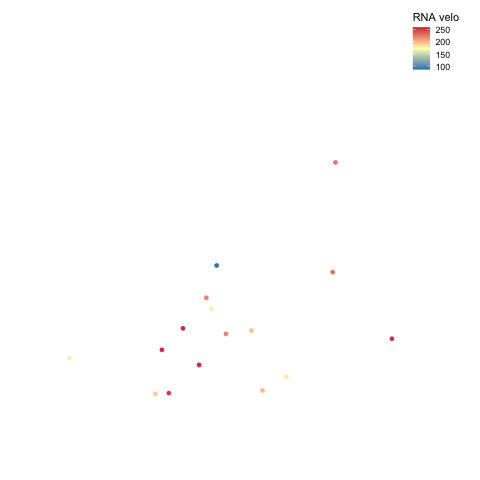

In [10]:
%%R -i downsampled_INTepi

veloQcolours <- quantile(downsampled_INTepi@meta.data$velocity_length, c(0.05,0.95), na.rm = TRUE)

ggplot(
  as.data.frame(subset(downsampled_INTepi, subset=(
                              orig.ident=="cocultWTFib" & curatedCLUST%in%c(
                                "CSC", "proCSC", "revCSC","TA 1","TA 2", 
                                "ER Stress","Goblet / DCS","Early Enterocyte","Late Enterocyte"))
                       )@reductions$phate_epi@cell.embeddings), 
  aes(x=phateepi_1, y=phateepi_2)) + #With subset call phate_epi_ gets renamed to phateepi_
  geom_point(aes(color=subset(downsampled_INTepi, subset=(
                              orig.ident=="cocultWTFib" & curatedCLUST%in%c(
                                "CSC", "proCSC", "revCSC", "TA 1", "TA 2", 
                                "ER Stress", "Goblet / DCS", "Early Enterocyte", "Late Enterocyte")))@meta.data$velocity_length)) +
  scale_colour_gradientn(colors=c("#3288BD","#FEFEBD","#D53E4F"),
                         limits=veloQcolours, oob=scales::squish
                         ) +
  egg::theme_article() + #Minimalist theme
  theme(
                            legend.position = c(.98, 1),
                            legend.justification = c("right", "top"),
                            legend.box.just = "right",
                            legend.margin = margin(6, 6, 6, 6),
                            axis.text = element_blank(),
                            axis.ticks=element_blank(),
                            panel.border = element_blank() #No boxes
                                ) +
  labs(title = NULL, x=NULL, y=NULL, fill="Density",color="RNA velo")+
  scale_x_continuous(limits = c(-0.035,0.05), expand = c(0, 0)) +
  scale_y_continuous(limits = c(-0.025,0.07), expand = c(0, 0))

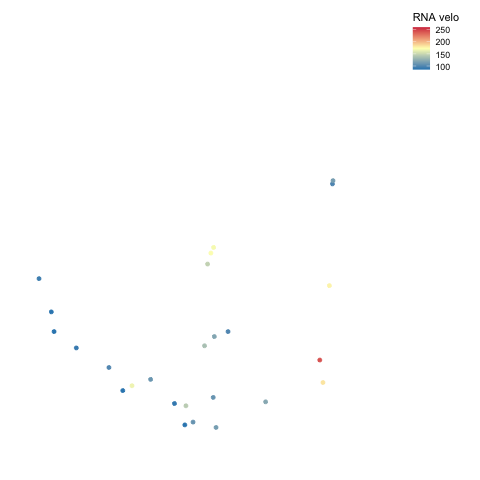

In [11]:
%%R -i downsampled_INTepi

veloQcolours <- quantile(downsampled_INTepi@meta.data$velocity_length, c(0.05,0.95), na.rm = TRUE)

ggplot(
  as.data.frame(subset(downsampled_INTepi, subset=(
                              orig.ident=="monoAK" & curatedCLUST%in%c(
                                "CSC", "proCSC", "revCSC","TA 1","TA 2", 
                                "ER Stress","Goblet / DCS","Early Enterocyte","Late Enterocyte"))
                       )@reductions$phate_epi@cell.embeddings), 
  aes(x=phateepi_1, y=phateepi_2)) + #With subset call phate_epi_ gets renamed to phateepi_
  geom_point(aes(colour=subset(downsampled_INTepi, subset=(
                              orig.ident=="monoAK" & curatedCLUST%in%c(
                                "CSC", "proCSC", "revCSC", "TA 1", "TA 2", 
                                "ER Stress", "Goblet / DCS", "Early Enterocyte", "Late Enterocyte")))@meta.data$velocity_length)) +
  scale_colour_gradientn(colors=c("#3288BD","#FEFEBD","#D53E4F"),
                         limits=veloQcolours, oob=scales::squish
                         ) +
  egg::theme_article() + #Minimalist theme
  theme(
                            legend.position = c(.98, 1),
                            legend.justification = c("right", "top"),
                            legend.box.just = "right",
                            legend.margin = margin(6, 6, 6, 6),
                            axis.text = element_blank(),
                            axis.ticks=element_blank(),
                            panel.border = element_blank() #No boxes
                                ) +
  labs(title = NULL, x=NULL, y=NULL, fill="Density",color="RNA velo")+
  scale_x_continuous(limits = c(-0.035,0.05), expand = c(0, 0)) +
  scale_y_continuous(limits = c(-0.025,0.07), expand = c(0, 0))


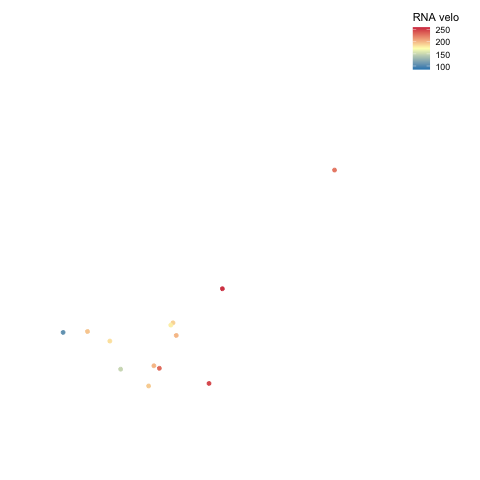

In [12]:
%%R -i downsampled_INTepi

veloQcolours <- quantile(downsampled_INTepi@meta.data$velocity_length, c(0.05,0.95), na.rm = TRUE)

ggplot(
  as.data.frame(subset(downsampled_INTepi, subset=(
                              orig.ident=="WTorg_WENR" & curatedCLUST%in%c(
                                "CSC", "proCSC", "revCSC","TA 1","TA 2", 
                                "ER Stress","Goblet / DCS","Early Enterocyte","Late Enterocyte"))
                       )@reductions$phate_epi@cell.embeddings), 
  aes(x=phateepi_1, y=phateepi_2)) + #With subset call phate_epi_ gets renamed to phateepi_
  geom_point(aes(colour=subset(downsampled_INTepi, subset=(
                              orig.ident=="WTorg_WENR" & curatedCLUST%in%c(
                                "CSC", "proCSC", "revCSC", "TA 1", "TA 2", 
                                "ER Stress", "Goblet / DCS", "Early Enterocyte", "Late Enterocyte")))@meta.data$velocity_length)) +
  scale_colour_gradientn(colors=c("#3288BD","#FEFEBD","#D53E4F"),
                         limits=veloQcolours, oob=scales::squish
                         ) +
  egg::theme_article() + #Minimalist theme
  theme(
                            legend.position = c(.98, 1),
                            legend.justification = c("right", "top"),
                            legend.box.just = "right",
                            legend.margin = margin(6, 6, 6, 6),
                            axis.text = element_blank(),
                            axis.ticks=element_blank(),
                            panel.border = element_blank() #No boxes
                                ) +
  labs(title = NULL, x=NULL, y=NULL, fill="Density",color="RNA velo")+
  scale_x_continuous(limits = c(-0.035,0.05), expand = c(0, 0)) +
  scale_y_continuous(limits = c(-0.025,0.07), expand = c(0, 0))

## CellRank

CellRank analysis was performed on the scvelo objects and ran using close to default parameters as exemplified below for the WT WENR condition.

### Terminal states

In [ ]:
VK_WENR = cr.tl.kernels.VelocityKernel(
    adWENR, backward=False).compute_transition_matrix(n_jobs=-2)
CK_WENR = cr.tl.kernels.ConnectivityKernel(
    adWENR, backward=False).compute_transition_matrix()
combK_WENR = 0.8*VK_WENR + 0.2*CK_WENR
combK_WENR

In [ ]:
estGPCCA_WENR = cr.tl.estimators.GPCCA(combK_WENR)
estGPCCA_WENR.compute_schur(n_components=24)
estGPCCA_WENR.plot_schur_matrix()

In [ ]:
estGPCCA_WENR.plot_spectrum(real_only=True)
estGPCCA_WENR

In [ ]:
estGPCCA_WENR.compute_macrostates(
    n_states=3, #Set 2 None for eigenegap location
    n_cells=120,
    cluster_key="curatedCLUST"
    )
# estGPCCA_WENR.plot_coarse_T()
estGPCCA_WENR.plot_macrostates(basis="X_phate")
estGPCCA_WENR.plot_macrostates(basis="X_phate", discrete=True)
estGPCCA_WENR.plot_macrostates(same_plot=False, basis="X_phate")

Subset of stable terminal macrostates

In [ ]:
#Fully automated approach: Based on group stability
estGPCCA_WENR.compute_terminal_states(method="top_n",n_states=2 ) #Asit otherwise fails here -#> look into this, seems to be and issue with self.set_terminal_states_from_macrostates(names, n_cells=n_cells, params=self._create_params())
# estGPCCA_WENR.compute_terminal_states() 
estGPCCA_WENR.compute_absorption_probabilities(
    keys=None, #None uses states from step above
    use_petsc=True,
    n_jobs=-2,
    time_to_absorption=None, #Which states to compute abs time towards. Can use "all"
    preconditioner = None #Recommended 2 use 'ilu' for badly conditioned problems
)

#Membership degree to a terminal state:
estGPCCA_WENR.plot_terminal_states(basis="X_phate")
estGPCCA_WENR.plot_terminal_states(basis="X_phate", discrete=True)
estGPCCA_WENR.plot_terminal_states(basis="X_phate", same_plot=False)
#Probability of traveling towards terminal state:
estGPCCA_WENR.plot_absorption_probabilities(basis="X_phate")
estGPCCA_WENR.plot_absorption_probabilities(basis="X_phate", same_plot=False)

### Initial states

In [ ]:
VKback_WENR = cr.tl.kernels.VelocityKernel(
    adWENR, backward=True).compute_transition_matrix(n_jobs=-2)
CKback_WENR = cr.tl.kernels.ConnectivityKernel(
    adWENR, backward=True).compute_transition_matrix()
combKback_WENR = 0.8*VKback_WENR + 0.2*CKback_WENR
combKback_WENR

In [ ]:
estGPCCAback_WENR = cr.tl.estimators.GPCCA(combKback_WENR)
estGPCCAback_WENR.compute_schur(n_components=24)
estGPCCAback_WENR.plot_schur_matrix()

In [ ]:
estGPCCAback_WENR.plot_spectrum(real_only=True)
estGPCCAback_WENR

In [ ]:
estGPCCAback_WENR.compute_macrostates(
    n_states=None, #Set 2 None for eigenegap location
    n_cells=120,
    cluster_key="curatedCLUST"
    )
# estGPCCAback_WTmono.plot_coarse_T() DOES NOT WORK WITH 1 MACROSTATE
estGPCCAback_WENR.plot_macrostates(basis="X_phate")
estGPCCAback_WENR.plot_macrostates(basis="X_phate", discrete=True)
estGPCCAback_WENR.plot_macrostates(same_plot=False, basis="X_phate")

Subset of stable intial macrostates

In [ ]:
#Fully automated approach: Based on group stability
estGPCCAback_WENR.compute_terminal_states() 
estGPCCAback_WENR.compute_absorption_probabilities(
    keys=None, #None uses states from step above
    use_petsc=True,
    n_jobs=-2,
    time_to_absorption=None, #Which states to compute abs time towards. Can use "all"
    preconditioner = None #Recommended 2 use 'ilu' for badly conditioned problems
)

#Membership degree to a terminal state:
estGPCCAback_WENR.plot_terminal_states(basis="X_phate")
estGPCCAback_WENR.plot_terminal_states(basis="X_phate", discrete=True)
estGPCCAback_WENR.plot_terminal_states(basis="X_phate", same_plot=False)
#Probability of traveling towards terminal state:
estGPCCAback_WENR.plot_absorption_probabilities(basis="X_phate")
estGPCCAback_WENR.plot_absorption_probabilities(basis="X_phate", same_plot=False)

### Initial to terminal dynamics

In [ ]:
scv.tl.recover_latent_time(
    adWENR,
    root_key = "initial_states_probs", end_key = "terminal_states_probs"
)

In [ ]:
cr.pl.cluster_fates(adWENR, mode="heatmap", cluster_key="curatedCLUST")
cr.pl.cluster_fates(adWENR, mode="clustermap", cluster_key="curatedCLUST")
cr.pl.cluster_fates(adWENR, mode="violin", cluster_key="curatedCLUST")

In [ ]:
scv.tl.paga(
    adWENR,
    groups="curatedCLUST",
    root_key="initial_states_probs", end_key="terminal_states_probs",
    use_time_prior="velocity_pseudotime"
)

In [ ]:
cluster_colours = {
    "ER Stress":"#CC00FF",
    "Early Enterocyte":"#00FF99",
    "Goblet / DCS":"#CC9900",
    "Late Enterocyte":"#006600",
    "Stem":"#6666FF",
    "Stem (Oncogene)":"#000099",
    "Stem (Stroma)":"#CC0000",
    "TA 1":"#FF99CC",
    "TA 2":"#FF6666"
}

In [ ]:
cr.pl.cluster_fates(
    adWENR,
    mode="paga_pie",
    cluster_key="curatedCLUST",
    basis="phate", #aUTO APPENDS X_, so need to only pass phate
    legend_kwargs={"loc": "top right out"},
    legend_loc="top left out",
    node_size_scale=1,
    edge_width_scale=1,
    max_edge_width=4,
    title="directed PAGA",
    node_colors = cluster_colours,
)